# Simple sentiment classifier

This binary classifier is trained on IMDB movie reviews. Given an input text it assigns it a label of positive or negative.

In [2]:
import tensorflow as tf
print(f"tf version: {tf.__version__}")

tf version: 2.3.0


In [4]:
!wget "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

--2020-11-02 21:12:22--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  24.6MB/s    in 4.9s    

2020-11-02 21:12:28 (16.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [5]:
import tarfile

tar = tarfile.open("aclImdb_v1.tar.gz", "r:gz")
tar.extractall(); tar.close()

In [ ]:
!pip install tree

     |████████████████████████████████| 71kB 2.7MB/s 
  Created wheel for tree: filename=Tree-0.2.4-cp36-none-any.whl size=7878 sha256=f68359111fdb7dd42ee008fa439ddb542be7f012349b6dde6c29b7d915bdd92d
  Stored in directory: /root/.cache/pip/wheels/c7/08/aa/42261411808c634cd1d0e9fe6cde5e78bf47c2c8028f3930af
Successfully built tree


In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [ ]:
!tree -L 2 aclImdb/

aclImdb/
├── imdbEr.txt
├── imdb.vocab
├── README
├── test
│   ├── labeledBow.feat
│   ├── neg
│   ├── pos
│   ├── urls_neg.txt
│   └── urls_pos.txt
└── train
    ├── labeledBow.feat
    ├── neg
    ├── pos
    ├── unsup
    ├── unsupBow.feat
    ├── urls_neg.txt
    ├── urls_pos.txt
    └── urls_unsup.txt

7 directories, 11 files


In [ ]:
!cat aclImdb/test/neg/62_2.txt

Humm, an Italian movie starred by David hasselhoff and Linda Blair, I wasn´t expecting very much, to be honest and in fact, I took even less than I was expecting. It doesn´t mean this movie is the worst I have seen because I have watched worse things than this but the plot was most of the times confusing and uninteresting and some good gore scenes are the only thing saving this. Apart from that you are going to love some special effects, they are really cheesy and bad. Now I only want to watch "Troll 3" by this same director, sure it is not going to be worse than that.

In [ ]:
!cat aclImdb/test/pos/2500_8.txt

This movie was a sicky sweet cutesy romantic comedy, just the kind of movie I usually dislike but this one was just cute enough to keep me interested. It was really funny in one moment (probably why I liked it) and then just as serious in the next. Plus, it had Ellen in it and I've always had a soft spot for her.<br /><br />Basically, the owner of a book store, Helen (Kate Capshaw) finds a love letter in one of the old couches in her store. She thinks it is for her and goes crazy trying to figure out who sent it. She has kind of shut herself off from the world, so it really throws her for a loop. Eventually, almost everyone connected with her finds this letter and they are all getting mixed signals which creates some really funny moments.<br /><br />Like I said, I am usually not one for this type of movie but I really wound up enjoying it and recommend it highly.

In [6]:
# create data frame for tensorflow
import os
import csv
import pandas as pd

with open('simple_sentiment_data.csv', mode='w') as csv_file:
    fieldnames = ['sentiment', 'text']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    for file in os.listdir("aclImdb/train/pos/"):
      if file.endswith(".txt"):
        with open(os.path.join("aclImdb/train/pos/", file)) as f:
          text = f.read().replace('\n', '')
          writer.writerow({'sentiment': 'pos', 'text': text})

    for file in os.listdir("aclImdb/train/neg/"):
      if file.endswith(".txt"):
        with open(os.path.join("aclImdb/train/neg/", file)) as f:
          text = f.read().replace('\n', '')
          writer.writerow({'sentiment': 'neg', 'text': text})

df = pd.read_csv('simple_sentiment_data.csv', encoding='utf8')
df.head()

,sentiment,text
0,pos,For all of the Has-Beens or Never Was's or for...
1,pos,Here Italy (I write from Venice). Why cancelat...
2,pos,Jim Carrey is back to much the same role that ...
3,pos,"Robert Urich was a fine actor, and he makes th..."
4,pos,"The film ""Cross Eyed"" by Adam Jones propels th..."


In [16]:
# create labels for tensorflow
df['labels'] = df['sentiment'].map({'pos': 1, 'neg': 0})
Y = df['labels'].values

# validate against half of training data
# experiment: validate against test data
from sklearn.model_selection import train_test_split
df_train, df_test, Ytrain, Ytest = train_test_split(df['text'], Y, test_size=0.5)



In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer

# convert text to sequences {x_1, ..., x_n}
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [18]:
# word index
word2idx = tokenizer.word_index
V = len(word2idx)
print(f"Number of unique tokens: {V}")

Number of unique tokens: 65020


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# pad sequences for N x T matrix
train = pad_sequences(sequences_train)
print(f"Shape of training data: {train.shape}")

T = train.shape[1]
print(f"Max sequence length: {T}")

test = pad_sequences(sequences_test, maxlen=T)
print(f"Shape of test data: {test.shape}")


Shape of training data: (12500, 2228)
Max sequence length: 2228
Shape of test data: (12500, 2228)


In [20]:
# model definition

from tensorflow.keras.layers import Input, GlobalMaxPooling1D, Dense
from tensorflow.keras.layers import Embedding, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# embedding dimensionality
D = 20

# hidden state dimensionality
M = 15

# set input shape with max sequence length
i = Input(shape=(T,))

# transform N x D matrix to N x T x D
x = Embedding(V + 1, D)(i)

x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)

# use sigmoid activation for binary classification
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [21]:
# compile model

from tensorflow.keras.optimizers import Adam

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# fit model

# stop training if validation accuracy doesn't increase
callback = EarlyStopping(monitor='val_accuracy', patience=1)

r = model.fit(
    train,
    Ytrain,
    epochs=10,
    validation_data=(test, Ytest),
    callbacks=[callback],
    verbose=1
)

Epoch 1/10
 92/391 [======>.......................] - ETA: 4:47 - loss: 0.6917 - accuracy: 0.5078

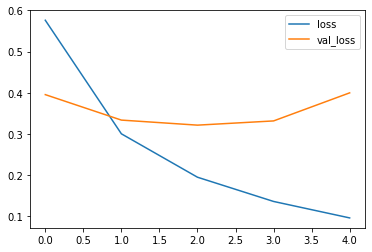

In [ ]:
import matplotlib.pyplot as plt

# plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

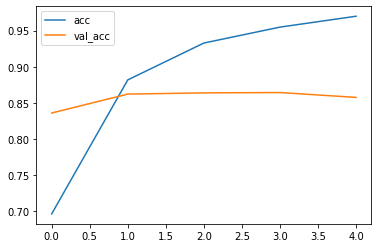

In [ ]:
# plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()